圖片總數為： 160
Found 160 files belonging to 2 classes.
Using 128 files for training.
Found 160 files belonging to 2 classes.
Using 32 files for validation.
['0', '1']
(32, 299, 299, 3)
(32,)


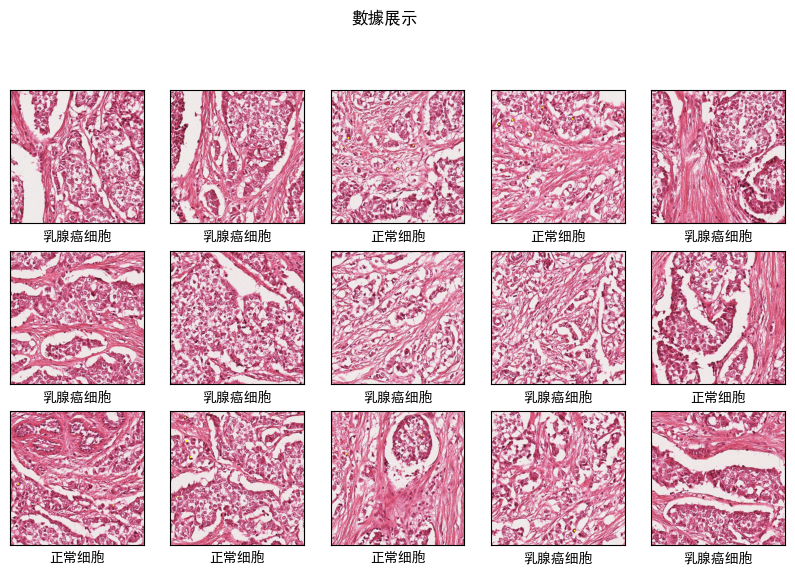

In [2]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os,PIL,pathlib,sys,glob,argparse
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

from keras.models import Model
from keras import __version__
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

warnings.filterwarnings("ignore")            
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    


import pathlib

data_dir = "C:\\Users\\HAUYU\\Desktop\\test_image\\A17"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print("圖片總數為：",image_count)
  
batch_size = 32
img_height = 299
img_width  = 299

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
AUTOTUNE = tf.data.experimental.AUTOTUNE
def train_preprocessing(image,label):
    return (image/255.0,label)

train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing) 
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)  
    .prefetch(buffer_size=AUTOTUNE)
)

plt.figure(figsize=(10, 8)) 
plt.suptitle("數據展示")

class_names = ["乳腺癌细胞","正常细胞"]

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]-1])

plt.show()

In [3]:
model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)
model.summary()


model.compile(optimizer= tf.train.RMSPropOptimizer(
                learning_rate,
                RMSPROP_DECAY,
                momentum=RMSPROP_MOMENTUM,
                epsilon=RMSPROP_EPSILON),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 100
PATIENCE  = 10
VERBOSE   = 1

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99** (x+NO_EPOCHS)) #改

earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)

checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)


train_model  = model.fit(train_ds,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=val_ds,
                  callbacks=[earlystopper, checkpointer, annealer])

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'RMSPropOptimizer'

In [ ]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

true_names = ["正常细胞","乳腺癌细胞"]
def plot_cm(labels, predictions):

    conf_numpy = confusion_matrix(labels, predictions)

    conf_df = pd.DataFrame(conf_numpy, index=true_names ,columns=true_names)  #改
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩陣',fontsize=15)
    plt.ylabel('真實值',fontsize=14)
    plt.xlabel('預測值',fontsize=14)

val_pre   = []
val_label = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        img_array = tf.expand_dims(image, 0) 
        prediction = model.predict(img_array)
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])
plot_cm(val_label, val_pre)

from sklearn import metrics
def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=true_names)) #改
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])
test_accuracy_report(model)